# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [4]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [31]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())    
    #plt.imshow(img)    
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

In [32]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        print(img.shape)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [33]:
sidelength = 128
cameraman = ImageFitting(sidelength)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

torch.Size([1, 256, 256])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([65536, 1])
torch.Size([1, 65536, 2])


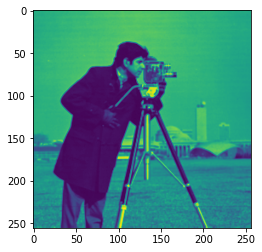

In [34]:
print(cameraman.pixels.shape)
plt.imshow(cameraman.pixels.cpu().view(sidelength,sidelength).detach().numpy())

total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
print(model_input.shape)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [ ]:
for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

In [48]:
print(model_input.shape)
#new_input = model_input+0.5
new_input = get_mgrid(sidelength*2, 2)
new_input = new_input.cuda()
model_output, coords = img_siren(new_input) 

img_grad = gradient(model_output, coords)
img_laplacian = laplace(model_output, coords)

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
plt.show()

torch.Size([1, 65536, 2])


RuntimeError: ignored

In [46]:
tmp = model_input.view(-1)
print(tmp.shape)
print(min(tmp), max(tmp))

torch.Size([131072])
tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


<a id='out_of_range'></a>
## Case study: Siren periodicity & out-of-range behavior

It is known that the sum of two periodic signals is itself periodic with a period that is equal to the least common multiple of the periods of the two summands, if and only if the two periods are rational multiples of each other. If the ratio of the two periods is irrational, then their sum will *not* be periodic itself.

Due to the floating-point representation in neural network libraries, this case cannot occur in practice, and all functions parameterized by Siren indeed have to be periodic.

Yet, the period of the resulting function may in practice be several orders of magnitudes larger than the period of each Siren neuron!

Let's test this with two sines.

In [ ]:
with torch.no_grad():
    coords = get_mgrid(2**10, 1) * 5 * np.pi
    
    sin_1 = torch.sin(coords)
    sin_2 = torch.sin(coords * 2)
    sum = sin_1 + sin_2
    
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(coords, sum)
    ax.plot(coords, sin_1)
    ax.plot(coords, sin_2)
    plt.title("Rational multiple")
    plt.show()
    
    sin_1 = torch.sin(coords)
    sin_2 = torch.sin(coords * np.pi)
    sum = sin_1 + sin_2
    
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(coords, sum)
    ax.plot(coords, sin_1)
    ax.plot(coords, sin_2)
    plt.title("Pseudo-irrational multiple")
    plt.show()

Though the second plot looks periodic, closer inspection shows that the period of the blue line is indeed larger than the range we're sampling here. 

Let's take a look at what the Siren we just trained looks like outside its training domain!

In [ ]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(1024, 2) * 50
    model_out, _ = img_siren(out_of_range_coords.cuda())
    
    fig, ax = plt.subplots(figsize=(16,16))
    ax.imshow(model_out.cpu().view(1024,1024).numpy())
    plt.show()

Though there is some self-similarity, the signal is not repeated on this range of (-50, 50).

## Fitting an audio signal
<a id='section_2'></a>

Here, we'll use Siren to parameterize an audio signal - i.e., we seek to parameterize an audio waverform $f(t)$  at time points $t$ by a SIREN $\Phi$.

That is we seek the function $\Phi$ such that:  $\mathcal{L}\int_\Omega \lVert \Phi(t) - f(t) \rVert \mathrm{d}t$  is minimized, in which  $\Omega$  is the domain of the waveform.

For the audio, we'll use the bach sonata:

In [ ]:
import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio

if not os.path.exists('gt_bach.wav'):
    !wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

Let's build a little dataset that computes coordinates for audio files:

In [ ]:
class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.rate, self.data = wavfile.read(filename)
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

Let's instantiate the Siren. As this audio signal has a much higer spatial frequency on the range of -1 to 1, we increase the $\omega_0$ in the first layer of siren.

In [ ]:
bach_audio = AudioFile('gt_bach.wav')

dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

# Note that we increase the frequency of the first layer to match the higher frequencies of the
# audio signal. Equivalently, we could also increase the range of the input coordinates.
audio_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                    hidden_layers=3, first_omega_0=3000, outermost_linear=True)
audio_siren.cuda()

Let's have a quick listen to ground truth:

In [ ]:
rate, _ = wavfile.read('gt_bach.wav')

model_input, ground_truth = next(iter(dataloader))
Audio(ground_truth.squeeze().numpy(),rate=rate)

We now fit the Siren to this signal.

In [ ]:
total_steps = 1000 
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = audio_siren(model_input)    
    loss = F.mse_loss(model_output, ground_truth)
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
    
        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

In [ ]:
final_model_output, coords = audio_siren(model_input)
Audio(final_model_output.cpu().detach().squeeze().numpy(),rate=rate)

As we can see, within few iterations, Siren has approximated the audio signal very well!

<a id='section_3'></a>
## Solving Poisson's equation

Now, let's make it a bit harder. Let's say we want to reconstruct an image but we only have access to its gradients!

That is, we now seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \nabla\Phi(\mathbf{x}) - \nabla f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 

In [ ]:
import scipy.ndimage
    
class PoissonEqn(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

#### Instantiate SIREN model

In [ ]:
cameraman_poisson = PoissonEqn(128)
dataloader = DataLoader(cameraman_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)
poisson_siren.cuda()

#### Define the loss function

In [ ]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

#### Train the model

In [ ]:
total_steps = 1000
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

model_input, gt = next(iter(dataloader))
gt = {key: value.cuda() for key, value in gt.items()}
model_input = model_input.cuda()

for step in range(total_steps):
    start_time = time.time()

    model_output, coords = poisson_siren(model_input)
    train_loss = gradients_mse(model_output, coords, gt['grads'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, train_loss, time.time() - start_time))

        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(128,128).detach().numpy())
        plt.show()
        
    optim.zero_grad()
    train_loss.backward()
    optim.step()

<a id='activations'></a>
## Initialization scheme & distribution of activations

We now reproduce the empirical result on the distribution of activations, and will thereafter show empirically that the distribution of activations is shift-invariant as well! 

In [ ]:
from collections import OrderedDict
import matplotlib
import numpy.fft as fft
import scipy.stats as stats


def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))

def format_x_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def format_y_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def get_spectrum(activations):
    n = activations.shape[0]

    spectrum = fft.fft(activations.numpy().astype(np.double).sum(axis=-1), axis=0)[:n//2]
    spectrum = np.abs(spectrum)

    max_freq = 100                
    freq = fft.fftfreq(n, 2./n)[:n//2]
    return freq[:max_freq], spectrum[:max_freq]


def plot_all_activations_and_grads(activations):
    num_cols = 4
    num_rows = len(activations)
    
    fig_width = 5.5
    fig_height = num_rows/num_cols*fig_width
    fig_height = 9
    
    fontsize = 5
        
    fig, axs = plt.subplots(num_rows, num_cols, gridspec_kw={'hspace': 0.3, 'wspace': 0.2},
                            figsize=(fig_width, fig_height), dpi=300)
    
    axs[0][0].set_title("Activation Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][1].set_title("Activation Spectrum", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][2].set_title("Gradient Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][3].set_title("Gradient Spectrum", fontsize=7, fontfamily='serif', pad=5.)

    x_formatter = matplotlib.ticker.FuncFormatter(format_x_ticks)
    y_formatter = matplotlib.ticker.FuncFormatter(format_y_ticks)

    spec_rows = []
    for idx, (key, value) in enumerate(activations.items()):    
        grad_value = value.grad.cpu().detach().squeeze(0)
        flat_grad = grad_value.view(-1)
        axs[idx][2].hist(flat_grad, bins=256, density=True)
        
        value = value.cpu().detach().squeeze(0) # (1, num_points, 256)
        n = value.shape[0]
        flat_value = value.view(-1)
            
        axs[idx][0].hist(flat_value, bins=256, density=True)
                
        if idx>1:
            if not (idx)%2:
                x = np.linspace(-1, 1., 500)
                axs[idx][0].plot(x, stats.arcsine.pdf(x, -1, 2), 
                                 linestyle=':', markersize=0.4, zorder=2)
            else:
                mu = 0
                variance = 1
                sigma = np.sqrt(variance)
                x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
                axs[idx][0].plot(x, stats.norm.pdf(x, mu, sigma), 
                                 linestyle=':', markersize=0.4, zorder=2)
        
        activ_freq, activ_spec = get_spectrum(value)
        axs[idx][1].plot(activ_freq, activ_spec)
        
        grad_freq, grad_spec = get_spectrum(grad_value)
        axs[idx][-1].plot(grad_freq, grad_spec)
        
        for ax in axs[idx]:
            ax.tick_params(axis='both', which='major', direction='in',
                                    labelsize=fontsize, pad=1., zorder=10) 
            ax.tick_params(axis='x', labelrotation=0, pad=1.5, zorder=10) 

            ax.xaxis.set_major_formatter(x_formatter)
            ax.yaxis.set_major_formatter(y_formatter)

In [ ]:
model = Siren(in_features=1, hidden_features=2048, 
              hidden_layers=10, out_features=1, outermost_linear=True)

input_signal = torch.linspace(-1, 1, 65536//4).view(1, 65536//4, 1)
activations = model.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

Note how the activations of Siren always alternate between a standard normal distribution with standard deviation one, and an arcsine distribution. If you have a beefy computer, you can put this to the extreme and increase the number of layers - this property holds even for more than 50 layers!

<a id='shift_invariance'></a>
## Distribution of activations is shift-invariant

One of the key properties of the periodic sine nonlinearity is that it affords a degree of shift-invariance. Consider the first layer of a Siren: You can convince yourself that this layer can easily learn to map two different coordinates to *the same set of activations*. This means that whatever layers come afterwards will apply the same function to these two sets of coordinates.

Moreoever, the distribution of activations similarly are shift-invariant. Let's shift our input signal by 1000 and re-compute the activations:

In [ ]:
input_signal = torch.linspace(-1, 1, 65536//4).view(1, 65536//4, 1) + 1000
activations = model.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

As we can see, the distributions of activations didn't change at all - they are perfectly invariant to the shift.